In [13]:
stock_symbol = 'AAPL'
test_model_mode = True
delete_model = False

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas_datareader as pdr

In [15]:
# Fetch historical data for the stock for the last 5 years
Stock = pd.DataFrame(yf.Ticker(stock_symbol).history(period = '5y'))

In [16]:
df = Stock.reset_index()
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-02-04 00:00:00-05:00,40.170486,41.190285,40.139291,41.091904,125982000,0.0000,0.0
1,2019-02-05 00:00:00-05:00,41.478224,42.010920,41.355850,41.794960,144406400,0.0000,0.0
2,2019-02-06 00:00:00-05:00,41.907742,42.128502,41.475830,41.809364,112958400,0.0000,0.0
3,2019-02-07 00:00:00-05:00,41.367846,41.737375,40.873544,41.017517,126966800,0.0000,0.0
4,2019-02-08 00:00:00-05:00,40.723518,41.125957,40.586157,41.065712,95280000,0.1825,0.0
...,...,...,...,...,...,...,...,...
1254,2024-01-29 00:00:00-05:00,192.009995,192.199997,189.580002,191.729996,47145600,0.0000,0.0
1255,2024-01-30 00:00:00-05:00,190.940002,191.800003,187.470001,188.039993,55859400,0.0000,0.0
1256,2024-01-31 00:00:00-05:00,187.039993,187.100006,184.350006,184.399994,55467800,0.0000,0.0
1257,2024-02-01 00:00:00-05:00,183.990005,186.949997,183.820007,186.860001,64885400,0.0000,0.0


In [17]:
#Importando as libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [18]:
# Sorting the original DataFrame by index
data = df.sort_index(ascending=True, axis=0)

# Creating a new DataFrame with 'Date' and 'Close' columns
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

# Populating the new DataFrame with 'Date' and 'Close' values
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [19]:
# Setting 'Date' column as the index
new_data.index = new_data['Date']

# Dropping the original 'Date' column
new_data.drop('Date', axis=1, inplace=True)

In [20]:
if test_model_mode:
    # Converting the new_data DataFrame values to a NumPy array
    dataset = new_data.values

    # Creating the training set (first 1100 rows)
    train = dataset[0:1100, :]

    # Creating the testing set (rows 1100 and beyond)
    valid = dataset[1100:, :]
else:
    # Suponha que você tenha os dados em um DataFrame chamado 'new_data'
    # Substitua 'new_data' pelo seu DataFrame real

    # Defina a duração da última semana para o conjunto de validação (7 dias)
    dias_ultima_semana = 7

    # Certifique-se de que o DataFrame esteja ordenado por data
    new_data = new_data.sort_index()

    # Encontre a data mais recente nos dados
    data_mais_recente = new_data.index.max()

    # Defina a data de início para o conjunto de treinamento (tudo, exceto os últimos 7 dias)
    train = data_mais_recente - pd.DateOffset(days=dias_ultima_semana)

    # Separe os conjuntos de treinamento e validação
    train = new_data[new_data.index < data_inicio_treinamento]
    valid = new_data[data_inicio_treinamento:]

    # Agora, 'conjunto_treinamento' é o conjunto de treinamento até a última semana, e 'conjunto_validacao' é a última semana

In [21]:
# Creating a MinMaxScaler object with the specified feature range (0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling the data in the 'dataset' variable
scaled_data = scaler.fit_transform(dataset)

In [22]:
x_train, y_train = [], []

# Creating sequences of past data with a window size of 90
for i in range(90, len(train)):
    x_train.append(scaled_data[i-90:i, 0])
    y_train.append(scaled_data[i, 0])

# Converting lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the input data to be suitable for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [23]:
import tensorflow as tf
tf.random.set_seed(7)

In [24]:
# Creating the Sequential model
model = Sequential()

# Adding the first LSTM layer with 50 units, returning sequences, and specifying input shape
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Adding the second LSTM layer with 50 units
model.add(LSTM(units=50))

LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) projetado para lidar com o problema de desaparecimento de gradientes em sequências de dados. Redes neurais recorrentes são adequadas para trabalhar com dados sequenciais, como séries temporais financeiras.

A principal limitação das RNNs tradicionais é que elas têm dificuldade em lidar com dependências de longo prazo em sequências. Isso ocorre porque, durante o treinamento, os gradientes que são propagados de volta através da rede podem se tornar muito pequenos (desvanecer) ou muito grandes (explodir), especialmente em sequências longas. Isso dificulta a retenção de informações relevantes por longos períodos.

As LSTMs foram introduzidas para superar esse problema. Elas têm unidades de memória especiais chamadas células de memória e portões (gates) que controlam o fluxo de informações dentro da célula. Os principais componentes de uma célula LSTM incluem:

Célula de Memória (Memory Cell): Mantém e atualiza informações ao longo do tempo.

Portão de Esquecimento (Forget Gate): Decide quais informações da célula de memória antiga devem ser mantidas ou esquecidas.

Portão de Entrada (Input Gate): Decide quais novas informações da entrada devem ser adicionadas à célula de memória.

Portão de Saída (Output Gate): Decide quais informações da célula de memória devem ser emitidas como saída.

Esses mecanismos permitem que as LSTMs capturem dependências de longo prazo em dados sequenciais, tornando-as eficazes em tarefas como previsão de séries temporais, tradução de linguagem natural e outras aplicações sequenciais complexas. Elas têm sido amplamente utilizadas em problemas onde a contextualização temporal é crucial.

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
Total params: 30600 (119.53 KB)
Trainable params: 30600 (119.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


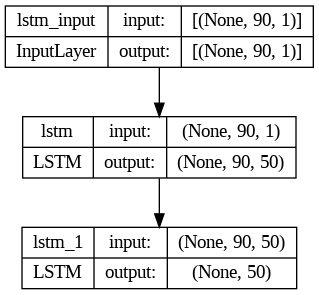

In [26]:
import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file='model_plot_LSTM.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
)

In [27]:
# Compiling the model with mean squared error loss and the Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])

# Training the model with the specified number of epochs, batch size, and verbosity
history = model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# Extrair métricas do histórico
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']
mape = history.history['mape']

# Criar DataFrame para facilitar a manipulação
metrics_df = pd.DataFrame({'Epoch': range(1, len(loss) + 1), 'Loss': loss, 'MAE': mae, 'MSE': mse, 'MAPE': mape})

# Criar subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Gráfico para Loss
axes[0, 0].plot(metrics_df['Epoch'], metrics_df['Loss'], label='Loss', color='blue')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Valor')
axes[0, 0].legend()

# Gráfico para MAE
axes[0, 1].plot(metrics_df['Epoch'], metrics_df['MAE'], label='MAE', color='orange')
axes[0, 1].set_title('MAE')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Valor')
axes[0, 1].legend()

# Gráfico para MSE
axes[1, 0].plot(metrics_df['Epoch'], metrics_df['MSE'], label='MSE', color='green')
axes[1, 0].set_title('MSE')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Valor')
axes[1, 0].legend()

# Gráfico para MAPE
axes[1, 1].plot(metrics_df['Epoch'], metrics_df['MAPE'], label='MAPE', color='red')
axes[1, 1].set_title('MAPE')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].legend()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()

In [ ]:
# Extracting the last 90 rows of the new_data DataFrame and scaling the data
inputs = new_data[len(new_data) - len(valid) - 90:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

# Creating sequences of past data for prediction
X_test = []
for i in range(90, inputs.shape[0]):
    X_test.append(inputs[i-90:i, 0])

# Converting X_test to a NumPy array
X_test = np.array(X_test)

# Reshaping the input data to be suitable for the LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting the closing prices using the trained LSTM model
closing_price = model.predict(X_test)

In [ ]:
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
plt.rcParams.update({'font.size': 22})

# Decreased figsize for a slightly smaller image
plt.figure(figsize=(18, 8))

# Supondo que 'closing_price' seja uma matriz 2D com formato (número de dias, número de recursos)
# Selecione a primeira coluna (ajuste isso com base em suas necessidades)
previsao_ultimos_7_dias = closing_price[-7:, 0]

# Crie um DataFrame para os últimos 7 dias
previsoes_df = pd.DataFrame(index=valid.index[-7:])
previsoes_df['Observado'] = valid['Close'].tail(7).values

# Certifique-se de que o comprimento das previsões seja igual ao número de dias desejados
previsao_ultimos_7_dias = np.concatenate([np.nan*np.ones(1), previsao_ultimos_7_dias])

previsoes_df['Previsão'] = previsao_ultimos_7_dias

# Plotando os preços de fechamento observados e previstos
plt.ylabel('Preço da Ação')
plt.xlabel('Data')
plt.plot(valid['Close'].values, label='Observado até a última semana')
plt.plot(previsoes_df['Observado'], label='Observado Últimos 7 Dias', marker='o')
plt.plot(previsoes_df['Previsão'], label='Previsão Últimos 7 Dias', marker='o')

# Adicionando legenda e ajustando sua posição
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

# Exibindo o gráfico
plt.show()


In [ ]:
plt.rcParams.update({'font.size': 22})

# Decreased figsize for a slightly smaller image
plt.figure(figsize=(18, 8))

train = new_data[:1100]
t_2020 = train['2020']
valid = new_data[1100:]

# Assuming 'closing_price' is a 2D array with shape (159, 50)
# Selecting the first column (you may adjust this based on your needs)
valid['Predictions'] = closing_price[:, 0]

# Plotting the observed and predicted closing prices
plt.ylabel('Preço da Ação')
plt.xlabel('Data')
plt.plot(train['Close'], label='Treino')
plt.plot(valid['Close'], label='Observado')
plt.plot(valid['Predictions'], label='Previsão')

# Adding legend and adjusting its position
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

# Displaying the plot
plt.show()

In [ ]:
valid[['Close', 'Predictions']].tail(10)

In [ ]:
# Increase the figure size
plt.figure(figsize=(18, 10))

# Plotting the observed and predicted closing prices with different colors
plt.plot(valid.index, valid['Close'], label='Observado', linestyle='-', linewidth=2, color='orange')
plt.plot(valid.index, valid['Predictions'], label='Previsão', linestyle='-', linewidth=2, color='green')

# Adding labels and title
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.title('Observado vs Previsão')

# Formatting the x-axis labels to show fewer dates with larger intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Set interval between ticks to 2 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotating x-axis labels vertically for better readability with less rotation
plt.xticks(rotation=45, ha='right')  # Rotate at 45 degrees and right-align

# Adding more space on the bottom for x-axis labels
plt.subplots_adjust(bottom=0.15)

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Defina as datas de início e fim para a janela desejada
data_inicio = pd.Timestamp('2024-01-20')
data_fim = pd.Timestamp('2024-01-28')

# Aumente o tamanho da figura
plt.figure(figsize=(18, 10))

# Plotagem dos preços de fechamento observados e previstos com cores diferentes
plt.plot(valid.index, valid['Close'], label='Observado', linestyle='-', linewidth=2, color='orange')
plt.plot(valid.index, valid['Predictions'], label='Previsão', linestyle='-', linewidth=2, color='green')

# Adicionando rótulos e título
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.title('Observado vs Previsão')

# Formatação dos rótulos do eixo x para mostrar mais datas
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Intervalo de 1 dia
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotacionando os rótulos do eixo x verticalmente para melhor legibilidade
plt.xticks(rotation=45, ha='center')  # Rotação vertical e alinhamento central

# Adicionando mais espaço na parte inferior para rótulos do eixo x
plt.subplots_adjust(bottom=0.15)

# Definindo a janela de datas personalizada
plt.xlim(data_inicio, data_fim)

# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()

In [ ]:
# Converta as strings de data para objetos Timestamp com informações de fuso horário
data1 = pd.Timestamp('2024-01-02', tz='America/New_York')
data2 = pd.Timestamp('2024-01-26', tz='America/New_York')

# Acesse os valores para as datas específicas usando .loc
valores_data1 = valid.loc[data1]
valores_data2 = valid.loc[data2]

# Exiba os valores para as datas específicas
print(f"Valores para {data1}:")
print(valores_data1)
print("\n")
print(f"Valores para {data2}:")
print(valores_data2)
print("\n")

# Calcula a diferença absoluta
diferenca_absoluta = valores_data2 - valores_data1

# Calcula a diferença percentual
diferenca_percentual = ((valores_data2 - valores_data1) / valores_data1) * 100

# Exibe os resultados
print(f"Diferença Absoluta entre {data1} e {data2}:")
print(diferenca_absoluta)
print("\n")
print(f"Diferença Percentual entre {data1} e {data2} em percentagem:")
print(diferenca_percentual)

# Configurações do gráfico
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 6))

# Plotagem da diferença absoluta
plt.subplot(2, 1, 1)
plt.bar(['Close', 'Predictions'], diferenca_absoluta, color=['orange', 'green'])
plt.title('Diferença Absoluta entre as Datas')
plt.ylabel('Diferença Absoluta')

# Plotagem da diferença percentual
plt.subplot(2, 1, 2)
plt.bar(['Close', 'Predictions'], diferenca_percentual, color=['orange', 'green'])
plt.title('Diferença Percentual em Percentagem entre as Datas')
plt.ylabel('Diferença Percentual (%)')

# Ajustes de layout
plt.tight_layout()

# Exibição do gráfico
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Substitua y_true pelos valores reais (Close)
y_true = valid['Close']

# Substitua y_pred pelos valores previstos (Predictions)
y_pred = valid['Predictions']

# Calcule o RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

# Calcule o MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE (Mean Absolute Error): {mae:.2f}")

# Calcule o R-squared (R2)
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R2): {r2:.4f}")

# Calcule o MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

RMSE (Root Mean Squared Error): É uma medida que penaliza erros maiores de forma mais significativa, representando a raiz quadrada da média dos quadrados dos erros.

MAE (Mean Absolute Error): Representa a média das diferenças absolutas entre os valores reais e previstos, dando uma ideia da magnitude média dos erros.

R-squared (R2): Indica a proporção da variabilidade nos dados reais que é explicada pelo modelo. Um valor mais próximo de 1 indica uma boa explicação da variabilidade.

MAPE (Mean Absolute Percentage Error): Representa a média percentual das diferenças absolutas entre os valores reais e previstos em relação aos valores reais. É uma métrica útil para entender o erro relativo percentual médio.

In [ ]:
!pip install pandas_market_calendars

In [ ]:
from pandas_market_calendars import get_calendar

# Substitua 'XNYS' pelo código da bolsa desejada
exchange_code = 'XNYS'
calendar = get_calendar(exchange_code)

# Especifique a data de início e número de dias úteis para prever no futuro
start_date = pd.Timestamp.now(tz='UTC').replace(hour=0, minute=0, second=0, microsecond=0)  # Use 'UTC' como o fuso horário de referência e remova as horas
num_dias_previsao = 30

# Obtenha os dias de negociação entre as datas especificadas
dias_mercado_aberto = calendar.valid_days(start_date=start_date, end_date=start_date + pd.DateOffset(days=num_dias_previsao), tz='UTC')

# Exiba a lista de dias de negociação de forma organizada
print("Dias de Negociação:")
for date in dias_mercado_aberto:
    print(date.strftime("%Y-%m-%d"))

# Agora você tem a lista de dias de negociação em 'dias_mercado_aberto'

In [ ]:
# Suponha que você tenha as datas correspondentes aos dados históricos
historical_dates = df['Date']  # Substitua 'your_dataframe' pelo seu DataFrame real

# Suponha que você já tenha treinado o modelo LSTM (como você fez anteriormente)

# Últimos pontos de dados no conjunto de treinamento
last_sequence = scaled_data[-90:]

# Gere previsões para os próximos 10 passos no tempo
future_predictions = []

# Obtenha a última data no conjunto de treinamento
last_date = pd.Timestamp(historical_dates.iloc[-1])

# Certifique-se de que a última data esteja no mesmo fuso horário que dias_mercado_aberto
last_date = last_date.tz_localize(None)  # Remover informações de fuso horário
last_date = last_date.tz_localize(dias_mercado_aberto.tz)  # Adicionar fuso horário de dias_mercado_aberto

try:
    next_date_index = dias_mercado_aberto.get_loc(last_date)
    if next_date_index == len(dias_mercado_aberto) - 1:
        raise KeyError
    next_date_index += 1
except KeyError:
    # Caso a chave não seja encontrada ou estejamos no último dia de mercado
    next_date_index = 0  # Comece do primeiro dia de mercado aberto

for i in range(num_dias_previsao):
    # Certifique-se de que não ultrapasse o final da lista de dias de mercado aberto
    if next_date_index >= len(dias_mercado_aberto):
        break

    # Obtenha a próxima data de mercado aberto
    next_date = dias_mercado_aberto[next_date_index]

    # Redimensione a sequência para ser aceita pelo modelo
    input_data = np.reshape(last_sequence, (1, last_sequence.shape[0], 1))

    # Faça uma previsão
    next_prediction = model.predict(input_data)

    # Adicione a data e a previsão à lista de previsões futuras
    future_predictions.append({'Date': next_date, 'Prediction': next_prediction[0, 0]})

    # Atualize a sequência para incluir a nova previsão
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction[0, 0]

    # Atualize o índice da próxima data de mercado aberto
    next_date_index += 1

# Converta as previsões futuras em DataFrame para facilitar a manipulação
future_predictions_df = pd.DataFrame(future_predictions)

# As previsões futuras estarão na escala original
future_predictions_df['Prediction'] = scaler.inverse_transform(np.array(future_predictions_df['Prediction']).reshape(-1, 1))

# Exiba as previsões futuras
print('\n')
print("Previsões Futuras:")
print(future_predictions_df)

In [ ]:
# Substitua 'Prediction' pelo nome real da coluna de previsões em seu DataFrame
plt.plot(future_predictions_df['Date'], future_predictions_df['Prediction'], color='red', label='Previsão')
plt.xlabel('Data')
plt.ylabel('Valor Previsto')
plt.title('Previsões Futuras')

# Rotacionar as datas no eixo x
plt.xticks(rotation=45, ha='right')  # 'rotation' define o ângulo de rotação e 'ha' define o alinhamento horizontal

plt.legend()
plt.tight_layout()  # Ajusta automaticamente o layout para evitar cortes

# Adicione a linha abaixo para exibir o gráfico
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 22})

# Decreased figsize for a slightly smaller image
plt.figure(figsize=(18, 8))

train = new_data[:1100]
t_2020 = train['2020']
valid = new_data[1100:]

# Assuming 'closing_price' is a 2D array with shape (159, 50)
# Selecting the first column (you may adjust this based on your needs)
valid['Predictions'] = closing_price[:, 0]

# Plotting the observed and predicted closing prices
plt.ylabel('Preço da Ação')
plt.xlabel('Data')
plt.plot(train['Close'], label='Treino')
plt.plot(valid['Close'], label='Observado')
plt.plot(valid['Predictions'], label='Previsão - Para Validação')

# Adicionando os dados de previsão ao gráfico
plt.plot(future_predictions_df['Date'], future_predictions_df['Prediction'], color='red', label='Previsão - Para o Futuro')

# Adicionando legenda e ajustando a posição
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

# Rotacionar as datas no eixo x
plt.xticks(rotation=45, ha='right')  # 'rotation' define o ângulo de rotação e 'ha' define o alinhamento horizontal

# Ajusta automaticamente o layout para evitar cortes
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
from datetime import datetime

# Obtenha as datas de início e fim da janela de previsão
start_date = future_predictions_df['Date'].iloc[0].strftime('%Y-%m-%d')
end_date = future_predictions_df['Date'].iloc[-1].strftime('%Y-%m-%d')

# Obtenha a data atual para incluir no nome do arquivo
current_date = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# Construa o nome do arquivo CSV com base nas datas da janela de previsão
csv_filename = f"previsoes_{stock_symbol}_{current_date}_[{start_date}_{end_date}].csv"

# Crie um DataFrame com as previsões
predictions_df = pd.DataFrame({'Date': future_predictions_df['Date'], 'Prediction': future_predictions_df['Prediction']})

# Salve o DataFrame como um arquivo CSV
predictions_df.to_csv(csv_filename, index=False)

print(f"Previsões salvas em {csv_filename}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Construa o caminho completo do arquivo CSV no Google Drive
csv_path = f"/content/drive/MyDrive/AI Financial Analisys/Predictions/{csv_filename}"

# Salve o DataFrame como um arquivo CSV
predictions_df.to_csv(csv_path, index=False)

print(f"Previsões salvas em {csv_path}")

In [ ]:
if delete_model:
    del model